# Crop Yield Prediction

Goal - To build a machine learning model to predict crop yield using agricultural, environmental, and historical data.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBRegressor

## Data Loading


In [2]:
df = pd.read_csv('yield_df.csv')
print('Columns:', df.columns.tolist())
df.head()

Columns: ['Unnamed: 0', 'Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']


,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


## Data Exploration

In [3]:
df.info()
display(df.describe(include='all'))
print('Missing values per column:')
print(df.isnull().sum())
print('Number of duplicate rows:', df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28242 non-null  int64  
 1   Area                           28242 non-null  object 
 2   Item                           28242 non-null  object 
 3   Year                           28242 non-null  int64  
 4   hg/ha_yield                    28242 non-null  int64  
 5   average_rain_fall_mm_per_year  28242 non-null  float64
 6   pesticides_tonnes              28242 non-null  float64
 7   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.7+ MB


,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,28242.000000,28242,28242,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
unique,NaN,101,10,NaN,NaN,NaN,NaN,NaN
top,NaN,India,Potatoes,NaN,NaN,NaN,NaN,NaN
freq,NaN,4048,4276,NaN,NaN,NaN,NaN,NaN
mean,14120.500000,NaN,NaN,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,8152.907488,NaN,NaN,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,0.000000,NaN,NaN,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,7060.250000,NaN,NaN,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,14120.500000,NaN,NaN,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,21180.750000,NaN,NaN,2008.000000,104676.750000,1668.00000,48687.880000,26.000000


Missing values per column:
Unnamed: 0                       0
Area                             0
Item                             0
Year                             0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64
Number of duplicate rows: 0


## Exploratory Data Analysis (EDA)

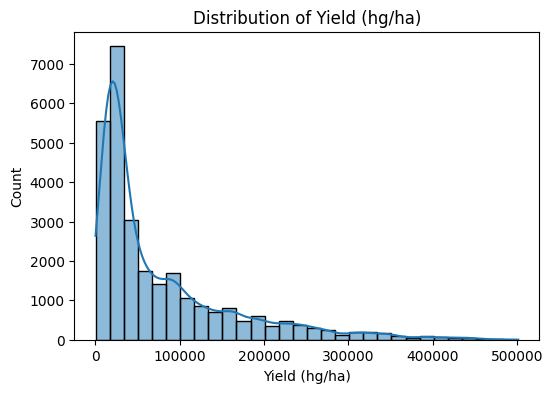

In [4]:
yield_col = None
for col in df.columns:
    if col.strip().lower() in ['hg/ha_yield', 'yield']:
        yield_col = col
        break
if yield_col is not None:
    plt.figure(figsize=(6,4))
    sns.histplot(df[yield_col], bins=30, kde=True)
    plt.title('Distribution of Yield (hg/ha)')
    plt.xlabel('Yield (hg/ha)')
    plt.show()
else:
    print("No yield column found. Please check the dataset.")

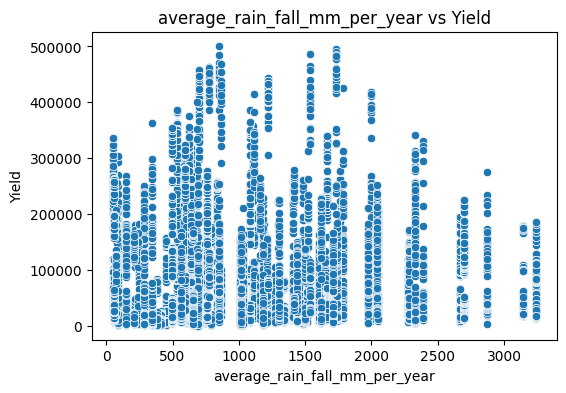

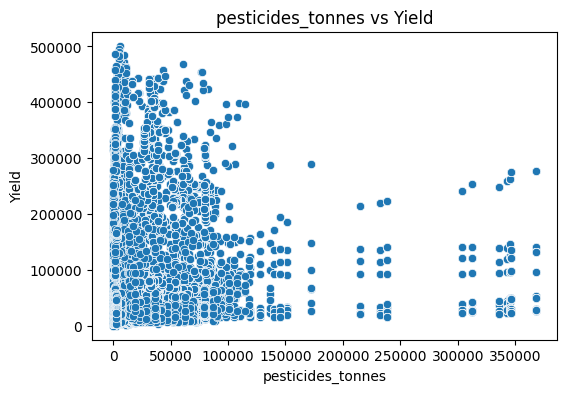

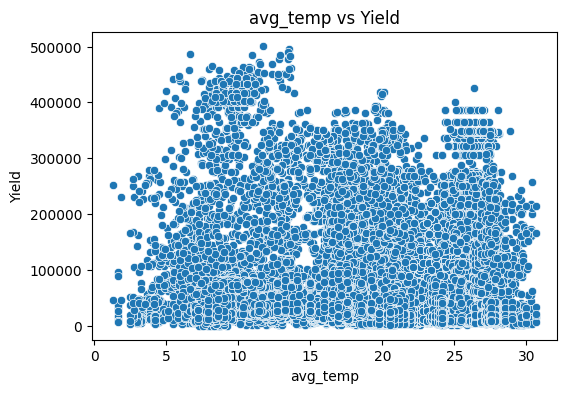

In [5]:
# Scatter Plots: Key Features vs Yield
features = ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
for feat in features:
    if feat in df.columns and yield_col is not None:
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=df[feat], y=df[yield_col])
        plt.title(f'{feat} vs Yield')
        plt.xlabel(feat)
        plt.ylabel('Yield')
        plt.show()

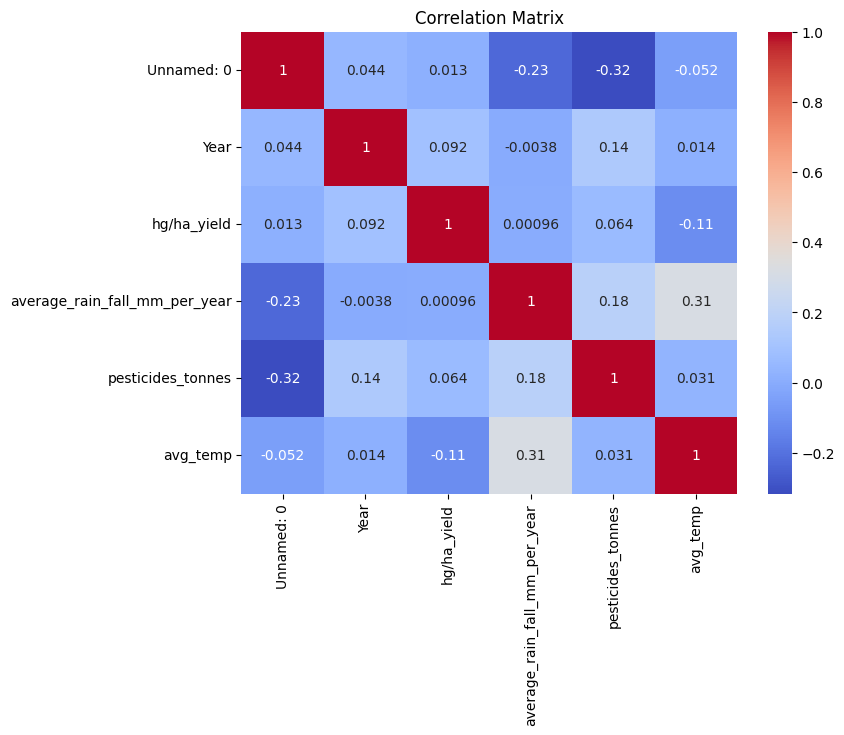

In [6]:
# Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Data Preprocessing

In [7]:
yield_col = None
for col in df.columns:
    if col.strip().lower() in ['hg/ha_yield', 'yield']:
        yield_col = col
        break
if yield_col is None:
    raise ValueError('No yield column found.')

df_clean = df.dropna(subset=[yield_col]).copy()

In [8]:
#  Impute Numerics with Median

num_cols = ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
for col in num_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

In [9]:
# Encode Categorical Columns

cat_cols = [col for col in ['Area', 'Item', 'Year'] if col in df_clean.columns]
df_clean = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)

In [10]:
# Remove Outliers (z-score > 3)
from scipy.stats import zscore

z = np.abs(zscore(df_clean.select_dtypes(include=[np.number])))
df_clean = df_clean[(z < 3).all(axis=1)]

## Feature Engineering

In [11]:
def feature_engineer(df):
    df = df.copy()
    if 'avg_temp' in df.columns and 'average_rain_fall_mm_per_year' in df.columns:
        df['Temp_Rain_Interaction'] = df['avg_temp'] * df['average_rain_fall_mm_per_year']
    if 'pesticides_tonnes' in df.columns and 'average_rain_fall_mm_per_year' in df.columns:
        df['Pesticide_Rain_Ratio'] = df['pesticides_tonnes'] / (df['average_rain_fall_mm_per_year'] + 1)
    return df

df_feat = feature_engineer(df_clean)

## Model Selection and Training

In [12]:
X = df_feat.drop(yield_col, axis=1)
y = df_feat[yield_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression Model

In [13]:
# Linear Regression Model

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression - MAE: {mae_lr:.2f}, MSE: {mse_lr:.2f}, RMSE: {rmse_lr:.2f}, R2: {r2_lr:.3f}")

Linear Regression - MAE: 24900.67, MSE: 1291306714.05, RMSE: 35934.76, R2: 0.756


## Random Forest Model

In [14]:
# Random Forest Model

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - MAE: {mae_rf:.2f}, MSE: {mse_rf:.2f}, RMSE: {rmse_rf:.2f}, R2: {r2_rf:.3f}")

Random Forest - MAE: 3371.21, MSE: 94960353.74, RMSE: 9744.76, R2: 0.982


## XGBoost Model

In [15]:
# XGBoost Model

xgb = XGBRegressor(random_state=42, verbosity=0)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - MAE: {mae_xgb:.2f}, MSE: {mse_xgb:.2f}, RMSE: {rmse_xgb:.2f}, R2: {r2_xgb:.3f}")

XGBoost - MAE: 8084.34, MSE: 210414320.00, RMSE: 14505.67, R2: 0.960


## Model Comparison and Prediction

In [16]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'MAE': [mae_lr, mae_rf, mae_xgb],
    'MSE': [mse_lr, mse_rf, mse_xgb],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb],
    'R2': [r2_lr, r2_rf, r2_xgb]
})
display(results)
best_idx = results['R2'].idxmax()
best_model_name = results.loc[best_idx, 'Model']
print(f'Best Model: {best_model_name}')
if best_model_name == 'Linear Regression':
    best_pred = y_pred_lr
elif best_model_name == 'Random Forest':
    best_pred = y_pred_rf
else:
    best_pred = y_pred_xgb
print('Sample predictions from best model:', best_pred[:5])

,Model,MAE,MSE,RMSE,R2
0,Linear Regression,24900.672685,1.291307e+09,35934.756352,0.756064
1,Random Forest,3371.207211,9.496035e+07,9744.760322,0.982061
2,XGBoost,8084.343262,2.104143e+08,14505.665100,0.960251


Best Model: Random Forest
Sample predictions from best model: [ 6202.38 25442.07 32670.14 11710.19 27079.  ]


In [17]:
# Export model and columns for Flask app
import pickle
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)
with open('model_columns.pkl', 'wb') as f:
    pickle.dump(list(X.columns), f)